# Seminars

In the seminars, we will use an opensource simulator (MUST) to understand how ultrasound images are generated by processing the recieved echos from scatterers. We will explore how different parameters of the ultrasound probe, and the available options on the emmited wave affect image generation. The seminars are organised as follows, and each consists of a python notebook with a code skeleton and instructions.

1- *Radiofrequency:* Understand how signals are emmited by the probe, and how are their reflected waves recieved. (4h)
2- *B-mode*:  (4h)
3- *Doppler:* Understand how we can measure velocities of scatterers using (4h)

After each seminar, 

Instructions: 
- Read the seminar instructions and explanations. Exercises will require you to complete code, change parameters and/or comment the results.
- REMEMBER TO ADD ALL REFERENCES AND CORRECTLY QUOTE MATERIAL
- Any attempt of cheating (copying from others, copying from internet, etc.) will result in a 0 grade for the whole course and disciplinary action.
- At the end, upload the report in the "Campus global". There are separated deliverables for the report and the python code.
- Be brief in the report. Most questions are answered in a single sentence.

Hints for the code:
- Most of the parts that you need to complete are just a few lines.
- When you need to test many parameters, you can copy paste a cell several times, or use a for loop, so you don't lose previous progress.
- Look at the example notebooks! They are a python version of the same notebooks available for the Matlab version, and contain most of the code that you need to complete the exercises. Note: copy-pasting code from this is not considered plagiarism, as long as there is a comment specifying the exact source (file and cell number).

## About MUST
MUST (Matlab UltraSound Toolbox) is an open source source to process ultrasound signals, as well as simulate. It was developped by Damien Garcia, an INSERM researcher at the CREATIS lab in Lyon, France. The library is based on the theory of linear scattering and Huygens principle, that states that each scatterer emits a spherical wave when stimulated by an incoming wave. Here, we will use a Python port of that toolbox. It is under development, so not all functionalities are available yet (namely 3D and speckle tracking are missing at the time of writing).

The MATLAB documentation is more comprehensive, but keep in mind that python does not allow a variable number of return values, so it is assumed that it will always return the maximum number of arguments. You can find plenty of examples in the manual, and the webpage (https://www.biomecardio.com/MUST). The python version is available at ().

If you find any bug, discrepancies between the Matlab and Python versions, or bad performance, please report it in the github page, or send an email to (gabriel.bernardino@upf.edu, damien.garcia@creatis.insa-lyon.fr).

### Installation

There are several ways of using PyMUST, both of them start by downloading the code, either by cloning the repository or downloading the zip file. 

*Option 1*
Run the following at the beggining of each notebook:
```python 
os.path.append('yourpath/to/pymust/src')
 ```
 If you have maintained the same folder structure, the path from here is '../src' 

 *Option 2 [Advanced]*
Run"pip install -e ." in a terminal from the pymust main folder. This is better done from a conda environment to avoid conflicts.


# Seminar 1

The first seminar will serve as an introduction to pymust, and

In [1]:
def to_Db(X):
    if np.min(X) < 0:
        raise ValueError('Cannot convert negative values to dB')
    return 10 * np.log10(X/np.max(X))

def my_ifft(X, df, one_sided = True):
    if not one_sided:
        n = 2**pymust.utils.nextpow2(X.shape[-1]) # Remember that efficient FFT requires the number of samples to be a power of 2
        X_hat =  np.fft.fftshift(np.fft.ifft(X, n))
        t = np.linspace(0, n/df, n)
    else:
        n = 2**pymust.utils.nextpow2(X.shape[-1] - 1) # Remember that efficient FFT requires the number of samples to be a power of 2
        X_hat = np.fft.fftshift(np.fft.irfft(X, n))
        t = np.linspace(0, n/df, n)

    return t, X_hat


def my_fft(X, dt, one_sided = True):
    n = 2**pymust.utils.nextpow2(X.shape[-1]) # Remember that efficient FFT requires the number of samples to be a power of 2
    if not one_sided:
        X_hat =  np.fft.fft(X, n)
        f = np.fft.fftfreq(n, dt)
    else:
        X_hat = np.fft.rfft(X, n)
        f = np.fft.rfftfreq(n, dt)

    return f, X_hat

#If at some point you get a warning that you have too many figures open, you can use this function to close them all
def closeAllFigures():
    plt.close('all')

##  Emmited signal

The first step is to define a "param" struct, which will include the definition of the ultrasound probe. In the future, it will include as well as media parameter (speed of sound, attenuation) that will be useful for the simulation. This struct will be used as parameters to most MUST functions. During the first seminar, our transducer will have a single piezoelectrical element.

Here, we will generate the signal emmited by the transducer. The transducer is composed of many piezoelectrical elements, that when excited with an electrical current, will generate a pressure wave. This signals will be reflected back when they hit a scatterer, and will be recorded by the piezoelectrical element (which transform pressure waves to electrical signals when are in reading mode). The emmited signal is centered around a central frequency (fc), but since we are interested in emmiting a pulse[^1], there will be a certain bandwidth of frequencies involved. This bandwidth is expressed as a percentage of the central frequency, and has to be between 0 and 200. The first exercise is to understand how these parameters affect the emmited signal, and understand basic concepts of ultrasound signal processing.


 [^1]: except when doing continuous Doppler, where a single frequency signal is emmited

In [26]:
import pymust, pymust.utils, numpy as np
import matplotlib.pyplot as plt

# Define the parameters of the probe
param_single_element = pymust.utils.Param()
param_single_element.fc = 2.7e6
param_single_element.bandwidth = 76 

param_single_element.Nelements = 1

# Media parameter

# Description of the geometry of the probe - We will explore this in the next seminar.
param_single_element.radius = np.inf
param_single_element.kerf = 3e-05
param_single_element.width = 0.00027
param_single_element.pitch = 0.0003
param_single_element.height = 0.005


We will look at the pulse and probe functions, which are defined in the frequency domain. The pulse function is an "idealised pulse", that we would like to emmit. If you look at its definition (pymust/utils.py, getPulseSpectrumFunction), you will find that it is the combination of two cardinal sinus, one centered at +fc, and the other at the negative -fc. However, devices will not be able to emmit such signals, since they have a limited bandwidth which they can emmit. These limitations are represented by the probe function, which acts as a filter. This function depends basically on the bandwidth parameter, and is a bandpass filter with a bandwidth [in frequency] equal to fc * bw/100. There are several ways of measuring the bandwidth of a signal, since most of them are never exactly 0. We will use the -3dB bandwidth, which is the length of the interval where the signal is above -3dB of its maximum power. You can use the function to_Db to transform to decibels (remember to take the absolute value if it is a complex signal). 

*Note*: you will be asked to convert from the frequency to time domain, and viceversa using the Fourier transform. You have some functions above defined so you can use them.

/var/folders/s4/bzy_db252n15287qgjz2gfzh0000gn/T/ipykernel_95981/3369086490.py:4: RuntimeWarning: divide by zero encountered in log10


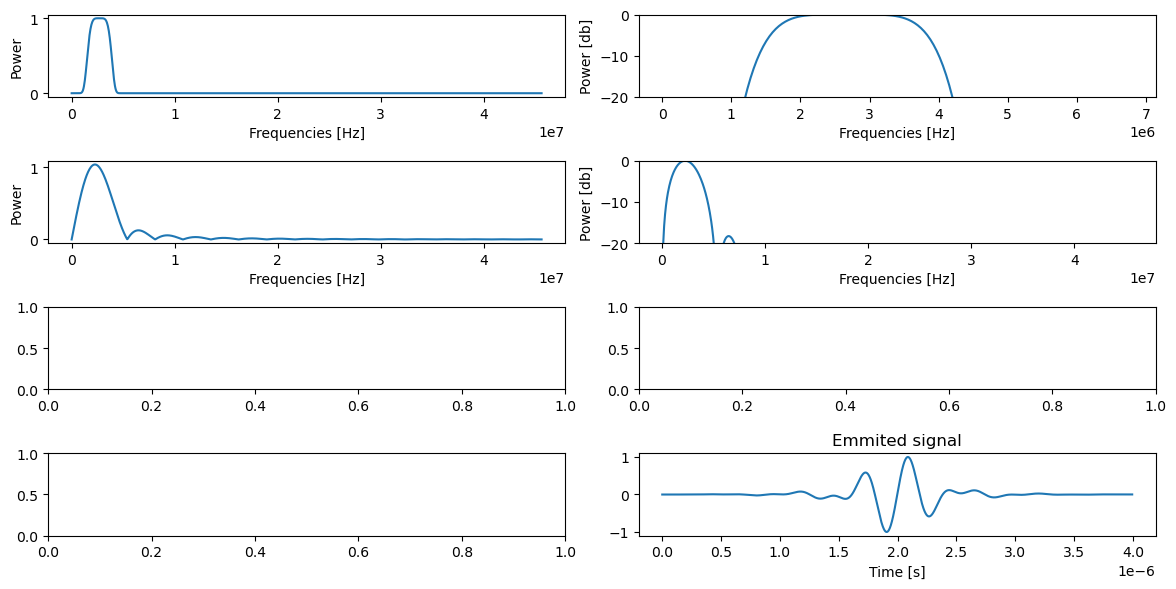

In [27]:
param.TXnow = 1 # To emmit different pulses

freqs = np.linspace(0,  6 * param.fc, 1000) #Plot only the spectrum between 0 and 3 times the central frequency
ws = 2* np.pi * freqs # The probe and actually work with angular  frequencies

probeFunction = param_single_element.getProbeFunction() # A function call that returns a function. This is allowed in Python
pulseFunction = param_single_element.getPulseSpectrumFunction() 

_, fs = plt.subplots(ncols = 2, nrows = 4, figsize =(12, 6)) 


# Probe function

plt.sca(fs[0,0]) # Plot in the first figure of the grid
plt.plot(freqs, probeFunction(ws))
plt.xlabel('Frequencies [Hz]')
plt.ylabel('Power')

plt.sca(fs[0,1]) 
plt.plot(freqs, to_Db(np.abs(probeFunction(ws))))
plt.xlabel('Frequencies [Hz]')
plt.ylabel('Power [db]')
plt.ylim(-20, 0)

# Pulse function

plt.sca(fs[1,0]) 
plt.plot(freqs, np.abs(pulseFunction(ws)))
plt.xlabel('Frequencies [Hz]')
plt.ylabel('Power')

plt.sca(fs[1,1]) 
plt.plot(freqs, to_Db(np.abs(pulseFunction(ws))))
plt.xlabel('Frequencies [Hz]')
plt.ylabel('Power [db]')
plt.ylim(-20, 0)


# Emmited pulse  - Your computation
# Do the convolution of the probe and pulse functions, and transform it to the time domain.
emmited_pulse_freq = ...

plt.sca(fs[2, 0]) 
# Here comes the emmited pulse in frequency domain

plt.sca(fs[2, 1]) 
# Here comes the emmited pulse in time domain


# Emmited pulse  - From pymust
pulse, t = pymust.getpulse(param_single_element)

plt.sca(fs[3, 0]) 
# Here comes the emmited pulse in frequency domain


plt.sca(fs[3, 1]) 
# Here comes the emmited pulse in frequency domain
plt.plot(t, pulse)
plt.xlabel('Time [s]')
plt.title('Emmited signal')

plt.tight_layout()

plt.savefig('Figures/s1_ex1.png')

# Questions
 

1. Why there are two cardinal sinus on the pulse spectrum? Note: you can obtain a single spectrum of a single sinc, and explain what happens when you apply the Fourier transform

1.  To obtain the emmited pulse, convolve the probe and pulse functions (to what does it correspond in the frequency domain?), and obtain both its time-domain and frequecny domain representatiosn. Compare with the result of the "getpulse" function from the pymust library in the time domain.

1. Convert the emmited pulse, obtained from the library, to the frequency domain

1. Compute the bandwidth of the resulting pulse (at -3db), and the central frequency (the frequency with more power). Change the central and bandwidth of the probe, and report its effect on these measures (try 3 different values). Compare the results with the theoretical values. [Note: they will not be the same]

1. Sometimes it is beneficial to emmit longer pulses, for instance when doing Doppler. For that, we can emmit several pulses using the parameter TXnow. Change it to 10, and report the effect on the bandwidth and central frequencies. Include the plots in your report. 

## A note on the system of reference

The ultrasound probe is centered at position x = 0, z = 0

Y coordinates refer to the elevation, and are not used in these tutorials. However, some functions might require to give them a value. In that case, you can use either an array with zeros, or the python empty list [].

# Received wave

In ultrasound, the emmited pulse interacts with some point scatterers, each of themscatterers will produce a spherical wave when excited by the emmited wave, and the part of it that reaches the probe will be registered. In MUST, other types of interactions (such as specular reflections or second order reflections are not considered). 

If we had a real research transducer, we could control its emmision parameters, and recover its signal. However, in this case, we will use a synthetic signal, which is obtained by the "simus" function. We will focus on the recieved signal, which is obtained via the "simus" function. This function requires the following parameters:
- Parameters of the probe, as before.
- Positions and reflecting coefficients of the reflecting scatterers. 
- Activation delay for each piezolectrical element of the probe (in this case is simply a vector with a single 0, since there is a single element in the transducer, but it will be explored in next exercise).



Text(0.5, 0, 'Time [s]')

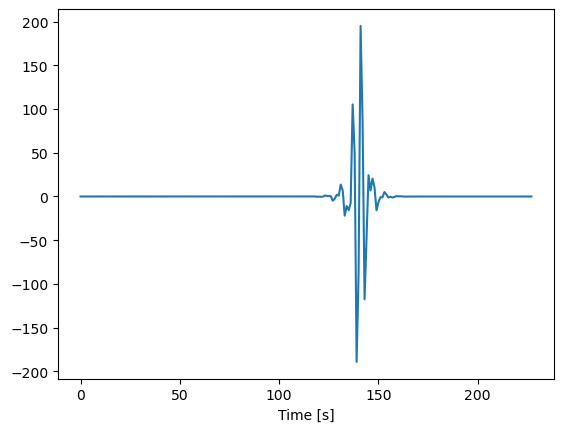

In [4]:
# Define the properties of the scatterer, need to define the x and z position of the scatterer (z is the depth, x is the lateral position with respect to the probe), and the reflecting coefficient RC
xScatterers = np.array([0])
zScatterers = np.array([1e-2])
RCScatterers = np.array([1])

# Define the activation delays, this will be important when we will have more complex transducers
activationDelaysTX = np.array([0]).reshape(1,1)

param.c = 1540

RF, _ = pymust.simus(xScatterers, zScatterers, RCScatterers,  activationDelaysTX, param)
fs = param.fs # Sampling frequency
nSamples = RF.shape[0] 
#t = ..  # Complete the time vector,
# RF is a matrix, since in most interesting cases, we will have a channel for each element of the transducer array, but here we will only have one element

#TODO: plot the 
plt.plot( RF[:,0])
plt.xlabel('Time [s]')

The recorded radiofrequency (RF) signal is a real valued signal, which is centered on the carrier frequency. Therefore, it will have oscillations around the central frequency that difficult its processing - for instance, it is difficult to determine where it has the maximum power. To solve this problem, the RF signal is demodulated, and transformed to a complex value functions whose absolute value is its envelope. This process is called *quadrature demodulation*, or IQ demodulation (IQ referring to In-phase / Quadrature) and we can use the rf2iq function. 

In [5]:
IQ = ...  #Generate the IQ signal, and plot both together. You need to use the function rf2iq. What is the shape and type of the IQ?


# Look at the python code in rf2iq, line 175. To do the downmixing, it multiplies the time-domain RF signal with another signal. What is the other signal? What would be the equivalent operation in the frequency domain?

1. Use simus to obtain. What is the bandwidth of the recieved signal? Compare it to the theoretical value that you would expect based on the central frequency and bandwidth of the probe.

1. Use the rf2iq signal to demodulate the recieved signal. Plot the demodulated signal in the time domain on top of the original signal.

1. What is the delay between the recieved signal (considering its maximal power point in the demodulated signal). Relate it to the distance from the transducer.

1. Compute the temporal length of the emmited pulse for different values of the bandwidth and TXnow. Compare the bandwidth and the length of the signal. [Note: this is related to Heisenberg uncertainty principle ]

## Recieved wave - attenuation

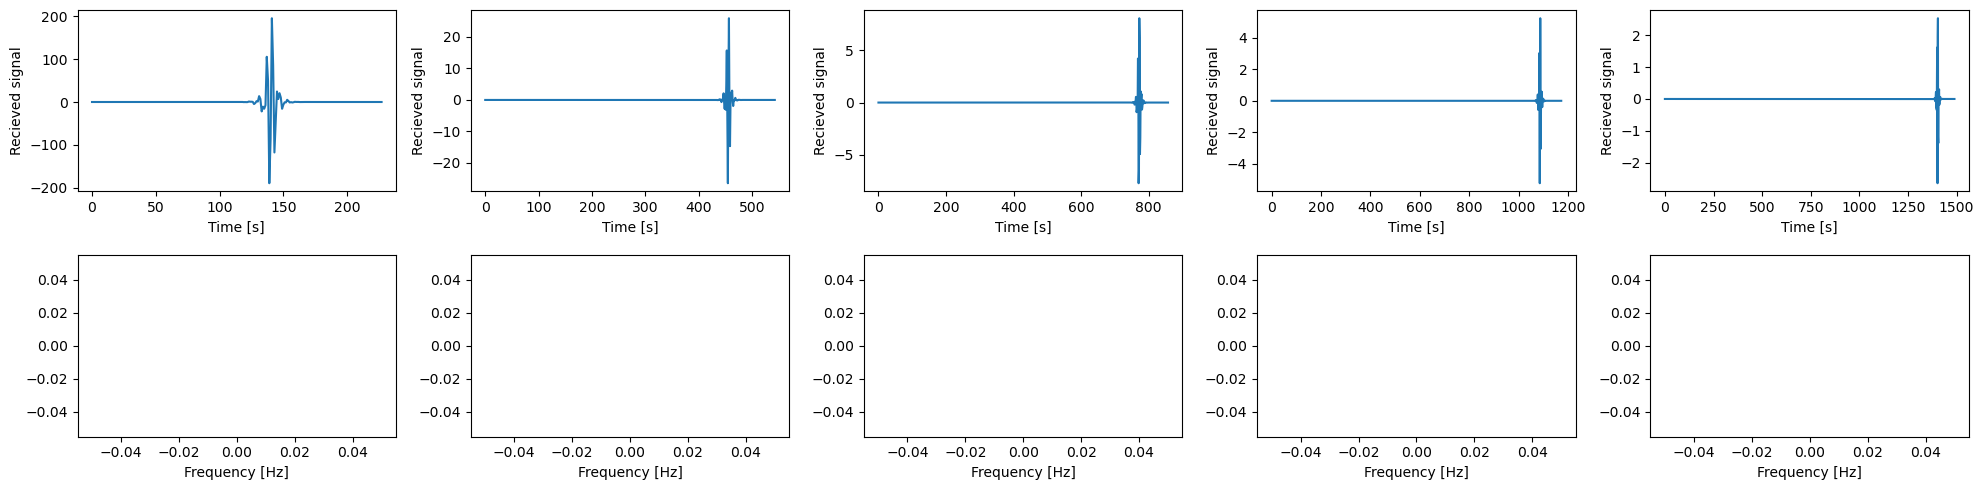

In [43]:
xScatterers = np.array([0])
zScatterers = np.array([1e-2])
RCScatterers = np.array([1])

# Define the activation delays, this will be important when we will have more complex transducers
activationDelaysTX = np.array([0]).reshape(1,1)

param.c = 1540



_, fs = plt.subplots(ncols = 5, nrows = 2, figsize = (20, 5))

distances = np.linspace(1e-2, 1e-1, num = 5)
for idx, f in np.ndenumerate(fs):
    i,j = idx[0], idx[1]
    if  i == 1:
        continue
    zScatterers = np.array([distances[j]]) # TODO: Change something that depends on i
    
    RF, _ = pymust.simus(xScatterers, zScatterers, RCScatterers,  activationDelaysTX, param_single_element)
    t = np.arange(RF.shape[0]) #TODO: 

    #TODO: compute the spectra of the radiofrequency using the Fourier transform. You can use my_fft defined above
    RF_spectrum, f = np.zeros(RF.shape[0], dtype = np.complex128), np.zeros_like(t)

    # Plot the signal
    plt.sca(fs[i,j])
    plt.plot(t, RF[:, 0])
    plt.xlabel('Time [s]')
    plt.ylabel('Recieved signal')
    
    # If not done anything, each of these plot will have its own scale on the x and y axis. Youcan control this with xlim and ylim 

    #TODO: uncomment the following line, and set an approppriate value so that all plots have the same scale
    # Hint: you can use a hardcoded value
    # plt.xlim(0, tMax)
    # plt.ylim (-vMax, vMax)

    # Plot the spectra
    plt.sca(fs[i + 1,j])
    plt.tight_layout()
    plt.plot(f, np.abs(RF_spectrum))
    plt.xlabel('Frequency [Hz]')
    plt.xlim(0, 3* param_single_element.fc)

1. Vary the distance between the source and the scatterer to [2cm, 4cm and 8cm]. What effect do you observe in the recieved intensity? and the spectrum?

1. Add the attenuation, and repeat the previous experiment.

1. Include time-gain compensation. What effect do you observe in the recieved intensity? and the spectrum?

## Several scatterers

THIS SHOULD BE MOVED TO SECTION 2

1. How many scattersrs do you visualise. Why?

1. Increase the bandwidth and TXNow to X and X. What can you say about the relationship between the signal length, and the axial resolution (the minimal distance in which you can discriminate between different objects) ?

1. Rotate the scatterers around the transducer. Do you observe any change in the recieved signal? Why?
 

# Several piezoelectrical elements.

Now we will study what happens when there is more than one scatterer

In [16]:
P.dtype, a.dtype, b.dtype

(dtype('float32'), dtype('complex64'), dtype('bool'))

## P-fields

A pressure field represents the amount of energy that reaches every point in the space. Each scatterer will emmit a spherical wave, with

In [17]:
param = pymust.getparam('L11-5v')

# Define the grid in which the pressure field will be computed

# Define the grid where the pressure will be computed
x = np.linspace(-2.5e-2,2.5e-2,150, dtype = np.float32); # in m
z = np.linspace(0,5e-2,150, dtype = np.float32); # in m
x,z = np.meshgrid(x,z);
y = []
txdel = pymust.txdelay(param, 0)
P, _, _ = pymust.pfield(x,y, z,txdel, param);

NameError: name 'xGrid' is not defined

## Transmit activation delays

The pressure waves we have been generating so far have been  plane waves without any tilt. This has made that the imaged region lies directly in front of the transducer, and with the same size. This is highly unpractical, as if we would like to scan a larger area, we would need to either use very large transducers, or move the transducer around. Moreover, this is not possible for cardiac applications, where the transducer must be positioned in the small apertures between the ribs. Here, we will show that by varying the activation delays of each piezoelectrical element, instead of activating them all at the same time, we can generate more types of waves that will allow to cover a larger area.

The waves emmited by each individual piezoelectric element can interact both constructively and destructively. By activating each element at different times, we can create waves following a different direction, and focusing at specific points. 

In [ ]:
param = pymust.getparam('L11-5v')

# Define the properties of the scatterer, need to define the x and z position of the scatterer (z is the depth, x is the lateral position with respect to the probe), and the reflecting coefficient RC
xScatterers = np.array([0, .0e-2])
zScatterers = np.array([1e-2, 3e-2 ])
RCScatterers = np.array([1, 1])

# Define the activation delays, this will be important when we will have more complex transducers
activationDelaysTX = pymust.txdelay(param, 0)


param.c = 1540

RF, _ = pymust.simus(xScatterers, zScatterers, RCScatterers,  activationDelaysTX, param);
ts = np.arange(RF.shape[0]) /param.fs

param_shorter_probe = pymust.getparam('L11-5v')
# Make the probe smaller by dividing the length of the pitch and kerf by 4. Do you need to modify other parameter?
param_shorter_probe.width /= 4
param_shorter_probe.pitch /= 4
param_shorter_probe.kerf /= 4

RF_shorter_probe, _ = pymust.simus(xScatterers, zScatterers, RCScatterers,  activationDelaysTX, param_shorter_probe);
ts_shorter_probe = np.arange(RF_shorter_probe.shape[0]) /param_shorter_probe.fs


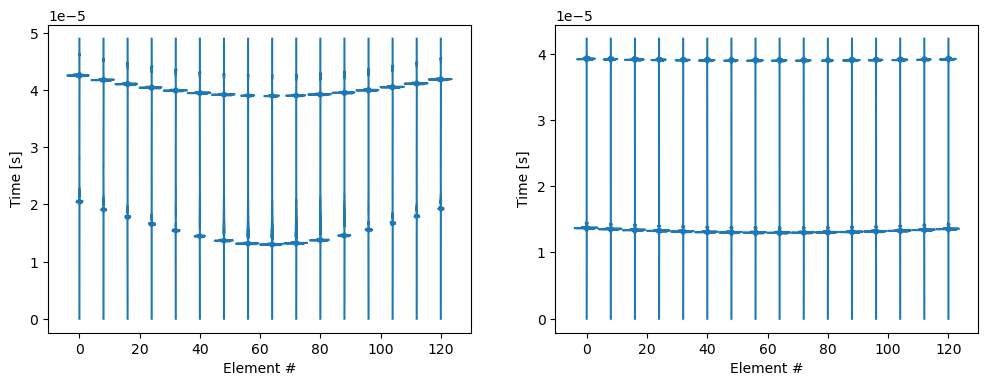

In [ ]:
def plotRF(RF, ts, stride = 8):
    stride = 8
    if RF.shape[1] % stride != 0:
        raise ValueError
    elementsToShow = np.arange(0, RF.shape[1], stride)
    for i, idx in enumerate(elementsToShow):
        plt.plot(idx + stride/2*RF[:,idx]/np.max(np.abs(RF[:,idx])), ts, c = '#1f77b4')
    plt.ylabel('Time [s]')
    plt.xlabel('Element #')

_, (f1, f2) = plt.subplots(ncols = 2, figsize = (12, 4))
plt.sca(f1)
plotRF(RF, ts)
plt.sca(f2)
plotRF(RF_shorter_probe, ts_shorter_probe)


[[-0.00945 -0.00915 -0.00885 -0.00855 -0.00825 -0.00795 -0.00765 -0.00735
  -0.00705 -0.00675 -0.00645 -0.00615 -0.00585 -0.00555 -0.00525 -0.00495
  -0.00465 -0.00435 -0.00405 -0.00375 -0.00345 -0.00315 -0.00285 -0.00255
  -0.00225 -0.00195 -0.00165 -0.00135 -0.00105 -0.00075 -0.00045 -0.00015
   0.00015  0.00045  0.00075  0.00105  0.00135  0.00165  0.00195  0.00225
   0.00255  0.00285  0.00315  0.00345  0.00375  0.00405  0.00435  0.00465
   0.00495  0.00525  0.00555  0.00585  0.00615  0.00645  0.00675  0.00705
   0.00735  0.00765  0.00795  0.00825  0.00855  0.00885  0.00915  0.00945]] [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
0.03705415948952061 10390.196547539634
1048 525


Text(0.5, 0, 'Element #')

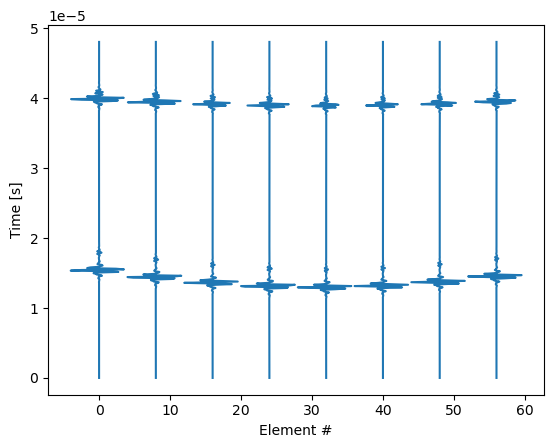

In [ ]:
# Parabolic profile cannot be seen in a phase array, when reducing the element

param = pymust.getparam('P4-2v')


# Define the properties of the scatterer, need to define the x and z position of the scatterer (z is the depth, x is the lateral position with respect to the probe), and the reflecting coefficient RC
xScatterers = np.array([0, .0e-2])
zScatterers = np.array([1e-2, 3e-2 ])
RCScatterers = np.array([1, 1])

# Define the activation delays, this will be important when we will have more complex transducers
activationDelaysTX = pymust.txdelay(param, 0)


param.c = 1540


RF, _ = pymust.simus(xScatterers, zScatterers, RCScatterers,  activationDelaysTX, param);


ts = np.arange(RF.shape[0]) /param.fs
stride = 8
elementsToShow = np.arange(0, param.Nelements, stride)
for i, idx in enumerate(elementsToShow):
    plt.plot(idx + stride/2*RF[:,idx]/np.max(np.abs(RF[:,idx])), ts, c = '#1f77b4')
plt.ylabel('Time [s]')
plt.xlabel('Element #')
plt.xlabel('Element #')


## 